# Imports

In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from joblib import parallel_backend, Parallel, delayed
num_cores = 10
import time

from scipy.integrate import odeint
from scipy.integrate import simps
from scipy.optimize import minimize

import seaborn as sns
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib import colors
import matplotlib as mpl

import pickle

import time
import copy

import os

import importlib

In [2]:
from ionization import Transmon_Module as TM
from ionization import Transmon_Module_numpy as TM_np

from ionization import branch_analysis as BA
from ionization import floquet_analysis as FA

# importlib.reload(FA)

In [3]:
import sys
sys.path.insert(1, "/Users/dumm3209/Desktop/Codes/VScode/PrettyPlots")
import pretty_plots 
list_colors = pretty_plots.list_colors

# Units

In [4]:
GHz,MHz,kHz = 2*np.pi,2*np.pi*1e-3,2*np.pi*1e-6
ns,us,ms = 1,1e3,1e6

# Main 

In [77]:
# PARAMÈTRES DIAGONALISATION 
max_charge = 200
n_trunc = 31
max_fock = 10


# Transmon

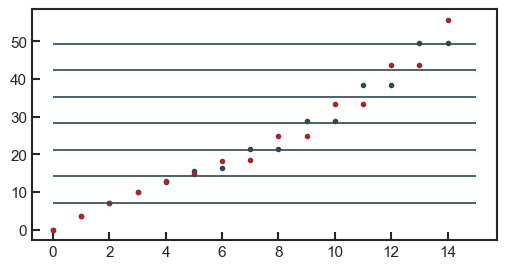

In [83]:
E_J_a_m = [8.717862654789487*GHz, -0.06694206359451146*GHz, 0.0034684306473925027*GHz]
E_J_b_m = [0, 0, 0]
E_C = 0.2166222390426093*GHz
g = 0.18647882941197633*GHz
omega_r = 7.047670130602469*GHz
omega_d = 7.0535*GHz

for n_g in [0,0.5]:
    
    Transmon_params = {'E_J_a_m':E_J_a_m,'E_J_b_m':E_J_b_m,'E_C':E_C,'g':g,'omega_r':omega_r,'max_charge':max_charge,'max_fock':max_fock,'n_trunc':n_trunc,'n_g':n_g}

    transmon_cavity = TM.Transmon_Cavity(Transmon_params)

    transmon = transmon_cavity.Transmon
    eigs_t = transmon.E
    eigv_t = transmon.Eigvecs
    H_t = transmon.H_t_eigbasis  # Hamiltonien diagonal
    I_t = transmon.I_t
    n_t = transmon.n_t_eigbasis  # charge operator in transmon eigenbasis
    omega_q = transmon.omega_q

    plt.plot((eigs_t[0:15]-np.min(eigs_t))/GHz,'.')

for i in range(1,8):
    plt.hlines(i*omega_d/GHz,0,15)


# Floquet

In [88]:
# PARAMÈTRES DIAGONALISATION 
max_charge = 200
n_trunc = 31
max_fock = 10

param_type = 'Xander IST'

if param_type == 'KIT' :
    # physical parameters : KIT transmon
    E_J_a_m = [8.717862654789487*GHz, -0.06694206359451146*GHz, 0.0034684306473925027*GHz]
    E_J_b_m = [0, 0, 0]
    E_C = 0.2166222390426093*GHz
    g = 0.18647882941197633*GHz
    omega_r = 7.047670130602469*GHz
    omega_d = 7.0535*GHz
    n_g = 0
    Transmon_params = {'E_J_a_m':E_J_a_m,'E_J_b_m':E_J_b_m,'E_C':E_C,'g':g,'omega_r':omega_r,'max_charge':max_charge,'max_fock':max_fock,'n_trunc':n_trunc,'n_g':n_g}


elif param_type == 'Xander IST' :
    # Xander parameters for IST
    E_J = 4.45 * GHz
    E_L = 4.44 * GHz
    E_C = 1 * GHz
    type_qubit = "L_shunt"
    phi_ext = np.pi
    g = 100 * MHz
    omega_r = 6*GHz
    omega_d = omega_r
    n_g = 0
    Transmon_params = {'E_J':E_J,'E_L':E_L,'phi_ext':phi_ext,'n_g':n_g,'E_C':E_C,'g':g,'omega_r':omega_r,'max_fock':max_fock,'n_trunc':n_trunc,'type':type_qubit}

else:
    print('wrong parameter type')

In [89]:
#Floquet
max_fock_floquet = 100
eps_d_step = 10 * MHz
eps_d_max = 2 * g * np.sqrt(max_fock_floquet)
eps_d_vec = np.arange(0,eps_d_max,eps_d_step)
N_times = 1
N_periods = 1
phi = 0

print(len(eps_d_vec))

200


In [90]:
# FLOQUET : generate and track

transmon_cavity = TM.Transmon_Cavity(Transmon_params)

transmon = transmon_cavity.Transmon
eigs_t = transmon.E
eigv_t = transmon.Eigvecs
H_t = transmon.H_t_eigbasis  # Hamiltonien diagonal
I_t = transmon.I_t
n_t = transmon.n_t_eigbasis  # charge operator in transmon eigenbasis
omega_q = transmon.omega_q
n_g = transmon.n_g

Floquet_params = {'n_t':n_t,'I_t':I_t,'H_t':H_t,'n_g':n_g,'num_cores':5,'omega_d':omega_d,'phi':phi,'eps_d_vec':eps_d_vec,'N_times':N_times,'N_periods':N_periods}

index_FA,f_energies,f_modes_0 = FA.generate_FA(Floquet_params,verbose=0)

In [91]:
overlap_max,f_modes_0_sorted,f_energies_sorted,index_Floquet = FA.track(n_trunc,f_energies,f_modes_0,Floquet_params,Transmon_params,eigs_t)

In [92]:
overlap_tot = FA.calculate_overlap_tot(n_trunc,f_modes_0_sorted,eps_d_vec)

In [93]:
########### Find Floquet resonances with overlap ############
N_t_sorted=[]
for q in range(n_trunc):
    N_t_q_sorted=[]
    for i in range(len(eps_d_vec)):
        N_t_q_sorted.append(FA.N_t(f_modes_0_sorted[q][i],Transmon_params))    
    N_t_sorted.append(np.array(N_t_q_sorted))

Text(0, 0.5, '$N_t$')

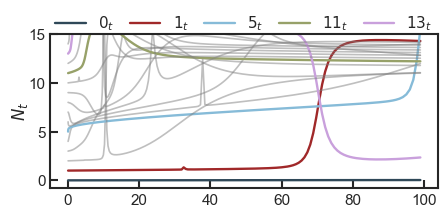

In [94]:
lwidth=1.7
plt.figure(figsize=(5,2))

for q in range(n_trunc):
    if q>1 and q!=11 and q!=5 and q!=13:
        plt.plot((eps_d_vec/2/g)**2,N_t_sorted[q],c='grey',alpha=0.5)
    else:
        plt.plot((eps_d_vec/2/g)**2,N_t_sorted[q],linewidth=lwidth,label='$i_t=0_t$')

legend_elements = [mpl.lines.Line2D([0], [0], c=list_colors[0], ls='-',lw=lwidth, label=r'$0_t$'),
                   mpl.lines.Line2D([0], [0], c=list_colors[1], ls='-',lw=lwidth, label=r'$1_t$'),
                   mpl.lines.Line2D([0], [0], c=list_colors[2], ls='-',lw=lwidth, label=r'$5_t$'),
                   mpl.lines.Line2D([0], [0], c=list_colors[3], ls='-',lw=lwidth, label=r'$11_t$'),
                   mpl.lines.Line2D([0], [0], c=list_colors[4], ls='-',lw=lwidth, label=r'$13_t$')]


plt.legend(handles=legend_elements, loc=(0,0.98),  ncol=5,columnspacing=1.02, frameon=False)

plt.ylim(-0.8,15)
#plt.xlim(0,200)

plt.ylabel('$N_t$',labelpad=-1)
#plt.savefig('Floquet_BA.pdf',transparent=True)

(-3.0, 3.0)

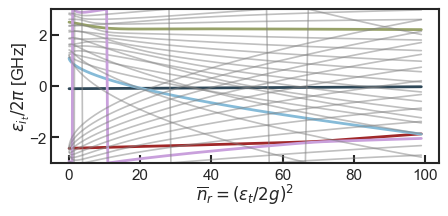

In [95]:
plt.figure(figsize=(5,2))

i_cut=391
for q in range(n_trunc):
    if q==3:
        plt.plot((eps_d_vec[:i_cut]/2/g)**2,np.array(f_energies_sorted[q][:i_cut])/GHz,c='grey',alpha=0.5)
        plt.plot((eps_d_vec[i_cut:]/2/g)**2,np.array(f_energies_sorted[q][i_cut:])/GHz,c='grey',alpha=0.5)

    elif q>1 and q!=11 and q!=5 and q!=13:
        plt.plot((eps_d_vec/2/g)**2,np.array(f_energies_sorted[q])/GHz,c='grey',alpha=0.5)
    else:
        plt.plot((eps_d_vec/2/g)**2,np.array(f_energies_sorted[q])/GHz,linewidth=2)

plt.xlabel(r'$\overline{n}_r=(\varepsilon_t/2g)^2$',labelpad=0)
plt.ylabel(r'$\varepsilon_{i_t}/2\pi$ [GHz]',labelpad=-2)
#plt.xlim(0,200)
plt.ylim(-omega_d/2/GHz,omega_d/2/GHz)

#plt.savefig('Floquet_quasi.pdf',transparent=True, bbox_inches='tight')

(0.0, 15.0)

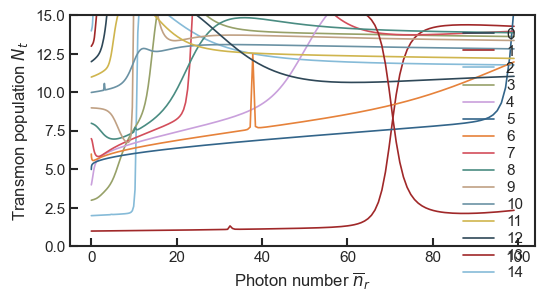

In [97]:
i=1
for q in range(15):
    plt.plot((eps_d_vec/2/g)**2,N_t_sorted[q],c=list_colors[q%12],label=q)
    
plt.xlabel('Photon number $\overline{n}_r$')
plt.ylabel('Transmon population $N_t$')
plt.legend()
plt.ylim(0,15)

## Find resonances automatically

In [98]:
import importlib
importlib.reload(FA)

<module 'ionization.floquet_analysis' from '/Users/dumm3209/Desktop/Codes/VScode/ionization/ionization/floquet_analysis.py'>

In [99]:
param_resonances={'index_min':0,
                 'value_min':1e-5,
                 'ratio_v':1,
                 'FWHM_size_min':5,
                 'FWHM_overlap_min':1e-5}

res_q_sort_clean,swap_statements,index_crit_tot,branch_tot,f_energies_sorted_q_tot,N_t_sorted_q_tot,gap_tot = FA.find_resonance_overlaps(f_energies_sorted,N_t_sorted,overlap_tot,param_resonances)

In [100]:
resonance_all=[]

for q in [0,1]:
    resonance_all_q = []
    if len(index_crit_tot[q])>0:
        eps_d_crit = eps_d_vec[index_crit_tot[q]]

        for i in range(len(eps_d_crit)):
            resonance_all_q.append([eps_d_crit[i],gap_tot[q][i]])
            
    resonance_all.append(resonance_all_q)

In [101]:
resonance_all_good = []
gap_all_good = []
for q in [0,1]:
    resonance_all_good_q = []
    gap_all_good_q = []

    if len(resonance_all[q])>0:
        for i in range(len(resonance_all[q])):
            if resonance_all[q][i][1]>0 :
                resonance_all_good_q.append(resonance_all[q][i][0])
                gap_all_good_q.append(resonance_all[q][i][1])
    resonance_all_good.append(resonance_all_good_q)
    gap_all_good.append(gap_all_good_q)

In [102]:
q = 0  # ground state
print(resonance_all_good[q])
print(gap_all_good[q])

[]
[]


In [103]:
q = 1  # ground state
print(resonance_all_good[q])
print(gap_all_good[q])

[np.float64(10.49291946298991)]
[np.float64(0.14279147766222877)]


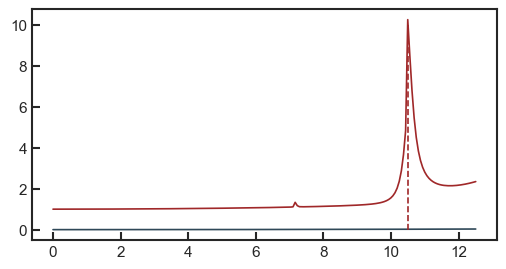

In [104]:
for q in range(2):
    plt.plot(eps_d_vec,N_t_sorted_q_tot[q])

    for j in range(len(resonance_all_good[q])):
        plt.vlines(resonance_all_good[q][j],0,10,color=list_colors[q],linestyle="dashed")